# Background
- **Author**: `<郭伊軒>`
- **Created At**: `<2025-11-1>`
- **Path to Training Data： discount-timing-DE.csv**
- **Path to Testing Data： discount-timing-DE.csv**
- **Model Specification 
    - Method：XGBoost classifer
    - Variables：  
    Dependent Variable (y):  
    [DiscountOrNot]  
    Independent Variables (X):   
    ['Age', 'MultiPlayer', 'PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W', 'SalePeriod', 'DiscountFreq3M', 'DLC_sum_1W', 'Sequel_sum_1W']
    - Tuning Parameters：['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', gamma', 'subsample', 'colsample_bytree', 'scale_pos_weight']
    - Optimization Method：  
       - 'n_estimators' = 100
       - 'max_depth' = 3
       - 'learning_rate' = 0.1 
       - 'min_child_weight' = 2
       - 'gamma' = 0.2
       - 'subsample' = 1
       - 'colsample_bytree' = 0.8
       - 'scale_pos_weight' = (len(y_train) - sum(y_train)) / sum(y_train)
    
- **Main Findings and Takeaways：**
    - In-sample `<Accuracy, F1, AUC>`:  
    DiscountOrNot(0.8070,    0.1511,  0.9028), DiscountDuringSale(0.9252,    0.2186,  0.9809), DiscountOutOfSale(0.7811,    0.0823,  0.9278)
    - Out-sample `<Accuracy, F1, AUC>`:  
    DiscountOrNot(0.7303,    0.0772,  0.7475), DiscountDuringSale(0.9355,    0.1129,  0.9793), DiscountOutOfSale(0.6466,    0.0519,  0.7512)
    - Feature Importance Ranking:  
  | 1 | PlayerGrowthRate1W  
  | 2 | FollowersGrowthRate1W   
  | 3 | SalePeriod  
  | 4 | Age  
  | 5 | DiscountFreq3M     
  | 6 | PositiveRateGrowthRate1W  
  | 7 | MultiPlayer   
  | 8 | SDLC_sum_1W   
  | 9 | Sequel_sum_1W   
- **Future Direciton：**

In [1]:
# Load packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, make_scorer


In [2]:
# Load the TRAINING data here and please finish all the data manipulation here.
input_data_file = "/Users/10610/Desktop/114-1 資料/steam-project/discount-timing-DE.csv"
#input_data_file = "/Users/user/Desktop/114-1 資料/steam-project/discount-timing-DE.csv"
df = pd.read_csv(input_data_file)

df_dummies = pd.get_dummies(df, columns=['GameID'], drop_first=True)

train = df_dummies[df_dummies['Date'] < '2025-01-01']
test = df_dummies[df_dummies['Date'] >= '2025-01-01']

def prepare_xy(df, feature_cols, target_col):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    # 將 bool 欄轉成 int
    X = X.astype({col: 'int' for col in X.select_dtypes(bool).columns})
    return X, y


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GameID,23938.0,461376.742000,298559.181056,10.000000,244850.000000,431730.000000,644930.000000,1.145360e+06
MultiPlayer,23938.0,0.464241,0.498730,0.000000,0.000000,0.000000,1.000000,1.000000e+00
ConstantDiscount,23938.0,0.214387,0.410405,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DiscountOrNot,23938.0,0.019885,0.139607,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DiscountDuration,23938.0,0.221196,1.715483,0.000000,0.000000,0.000000,0.000000,3.200000e+01
DiscountFreq3M,23938.0,1.797644,1.043279,0.000000,1.000000,2.000000,3.000000,6.000000e+00
Age,23938.0,7.634427,4.458471,2.389041,4.951370,6.323288,8.479452,2.484658e+01
AccumulatedPositiveRate,23938.0,0.928061,0.064186,0.738751,0.905517,0.953165,0.972651,9.929734e-01
SalePeriod,23938.0,0.146420,0.353534,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DiscountDuringSale,23938.0,0.008647,0.092590,0.000000,0.000000,0.000000,0.000000,1.000000e+00


### The actual modeling starts below
For the remaining blocks, make sure you have followed the guidelines as specified in [專案資料夾結構、檔案命名與文件規範](https://docs.google.com/document/d/1sl6gEFMdmiGsiNjLe17UmZ30xKxq15U0Mb2B-Jvusxg/edit?tab=t.33iie8ybx7s4).


## function

In [32]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # --- 第一張圖：Weight (使用頻率) ---
    xgb.plot_importance(model, importance_type='weight', ax=axes[0])
    axes[0].set_title("Feature Importance (Weight/Frequency)")
    axes[0].set_xlabel("Frequency (Count)")

    # --- 第二張圖：Gain (增益/影響力) ---
    xgb.plot_importance(model, importance_type='gain', ax=axes[1])
    axes[1].set_title("Feature Importance (Gain/Impact)")
    axes[1].set_xlabel("Gain (Average improvement)")

    plt.tight_layout() # 自動調整佈局，避免標籤重疊
    plt.show()



    y_pred_train = model.predict(X_train)
    y_prob_train = model.predict_proba(X_train)[:, 1]

    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)[:, 1]

    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    auc_train = roc_auc_score(y_train, y_prob_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_prob_test)
    cm = confusion_matrix(y_test, y_pred_test)

    results = {
        'Accuracy': [round(acc_train, 4), round(acc_test, 4)],
        'F1 score': [round(f1_train, 4), round(f1_test, 4)],
        'AUC': [round(auc_train, 4), round(auc_test, 4)]
    }

    row_names = ['train', 'test']

    result = pd.DataFrame(results, index=row_names)


    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", cm)
    return result


In [ ]:
def find_best_params_grid_searchCV(X_train, y_train, X_test, y_test, param_grid):
    # 1. 初始化 XGBClassifier
    xgb_clf = XGBClassifier(
        random_state=71, 
        objective="binary:logistic", 
        use_label_encoder=False, 
        eval_metric='logloss' # 設置一個預設的評估指標以避免警告
    )
    
    # 2. 設定交叉驗證策略
    # 針對不平衡資料，強烈建議使用 StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
    
    # 3. 定義評分標準
    # 對於不平衡資料，AUC 或 F1-score 通常優於單純的 accuracy
    scorer = make_scorer(roc_auc_score) # 這裡使用 AUC 作為主要優化目標
    
    # 4. 初始化 GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring=scorer,       # 使用定義好的評分標準
        cv=skf,               # 使用分層交叉驗證
        verbose=1,            # 顯示進度
        n_jobs=-1             # 使用所有可用的 CPU 核心進行並行計算
    )
    
    # 5. 執行網格搜索
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    y_prob_train = best_model.predict_proba(X_train)[:, 1]
    y_prob_test = best_model.predict_proba(X_test)[:, 1]


    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    auc_train = roc_auc_score(y_train, y_prob_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_prob_test)


    results = {
        'Accuracy': [round(acc_train, 4), round(acc_test, 4)],
        'F1 score': [round(f1_train, 4), round(f1_test, 4)],
        'AUC': [round(auc_train, 4), round(auc_test, 4)]
    }

   
    row_names = ['train', 'test']

    result = pd.DataFrame(results, index=row_names)
    
    # 返回最佳模型
    return grid_search.best_params_, result



# 1W

In [40]:
feature_cols = [
    'Age', 'AccumulatedPositiveRate', 'MultiPlayer', 'PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W', 
    'SalePeriod', 'DiscountFreq3M', 'DLC_sum_1W', 'Sequel_sum_1W'
]

baseline_model = XGBClassifier( 
    random_state=71, 
    objective="binary:logistic", 
    use_label_encoder=False, 
    eval_metric='logloss'
)

### 所有折扣

In [41]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountOrNot')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountOrNot')

In [42]:
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, pos_weight]
}

best_param, result = find_best_params_grid_searchCV(X_train, y_train, X_test, y_test, param_grid)
print(result)
print(best_param)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:37:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


       Accuracy  F1 score     AUC
train    0.8070    0.1511  0.9028
test     0.7303    0.0772  0.7475
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'scale_pos_weight': 47.21408450704225, 'subsample': 1.0}


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:54:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


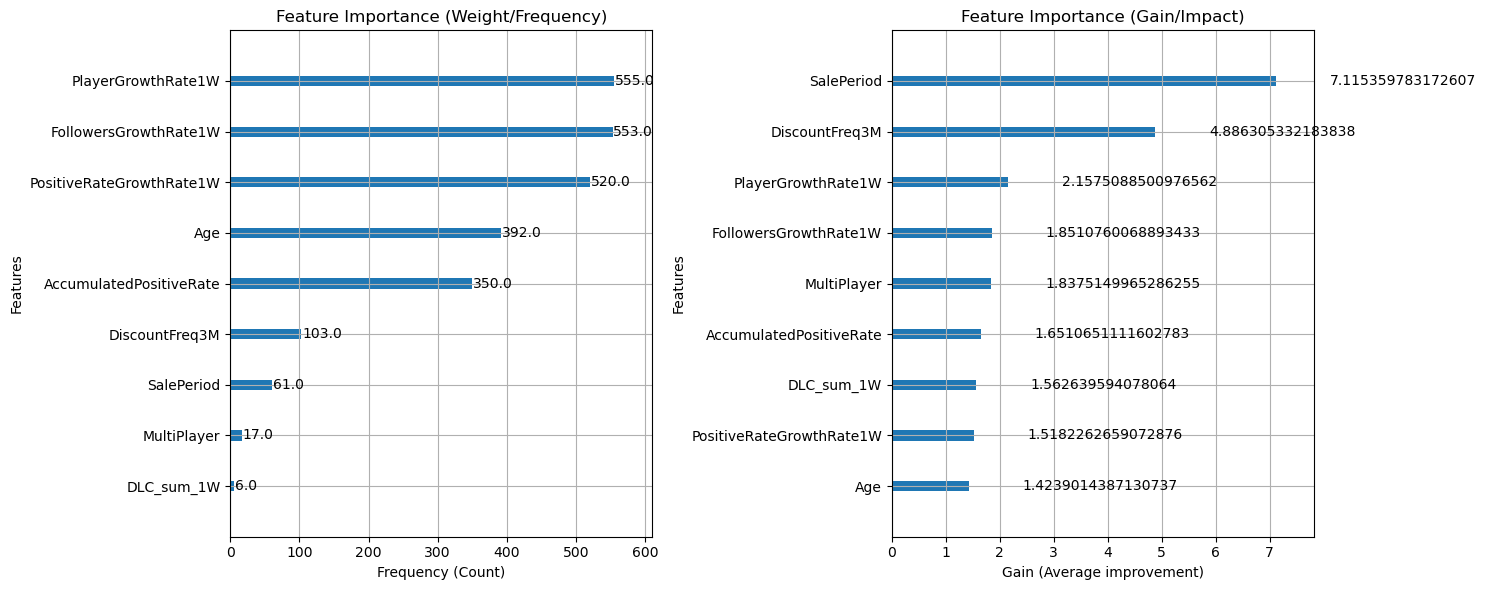


=== baseline ===
Confusion matrix:
 [[6642   59]
 [ 116    5]]


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:54:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


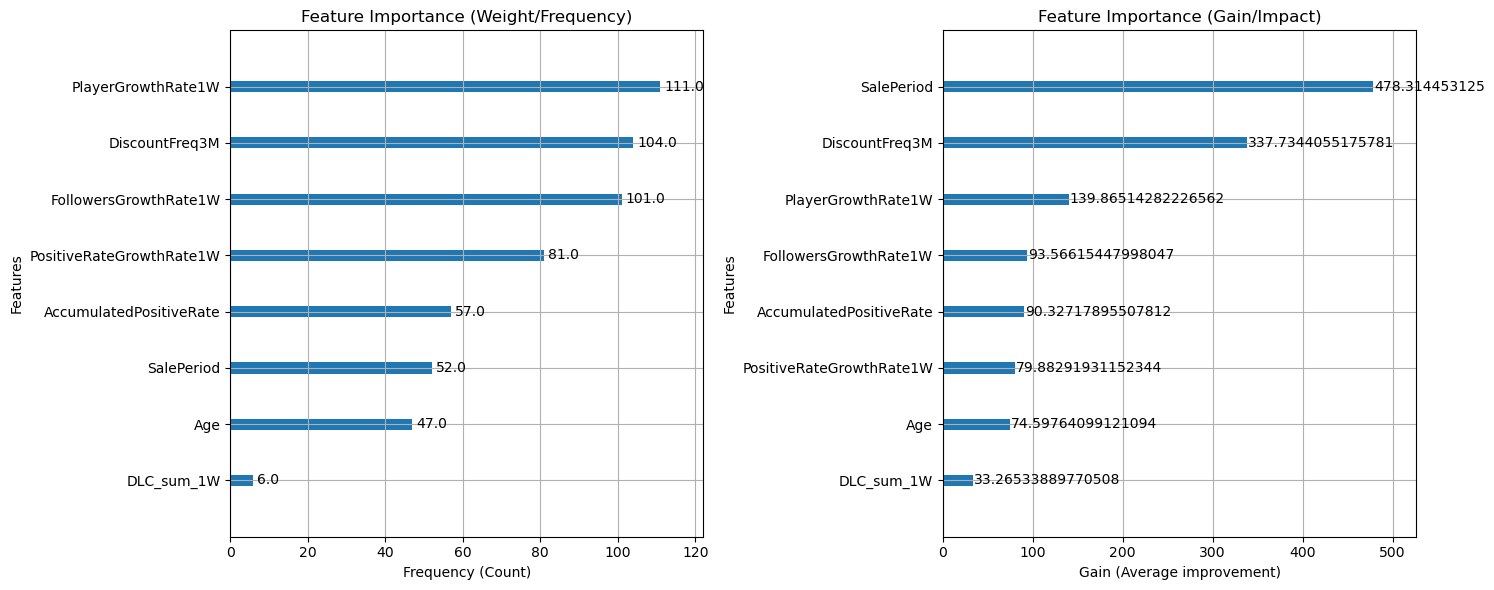


=== selection ===
Confusion matrix:
 [[4905 1796]
 [  44   77]]

模型比較結果:
                 Accuracy  F1 score     AUC
baseline  train    0.9928    0.7905  0.9993
          test     0.9743    0.0541  0.7290
selection train    0.8070    0.1511  0.9028
          test     0.7303    0.0772  0.7475


In [43]:
model = XGBClassifier( 
    random_state=71, 
    objective="binary:logistic", 
    use_label_encoder=False, 
    eval_metric='logloss',
    n_estimators = 100,
    max_depth = 3,
    min_child_weight = 2,
    learning_rate = 0.1,
    gamma = 0.1,
    subsample = 1,
    colsample_bytree = 0.8,
    scale_pos_weight = pos_weight
)

result1 = evaluate_model('baseline', baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model('selection', model, X_train, y_train, X_test, y_test)


combined_results = pd.concat([result1, result2], keys=['baseline', 'selection'])
print("\n模型比較結果:")
print(combined_results)

### 季節性折扣

In [35]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountDuringSale')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountDuringSale')

In [ ]:
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, pos_weight]
}

best_param, result = find_best_params_grid_searchCV(X_train, y_train, X_test, y_test, param_grid)
print(result)
print(best_param)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:53:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


       Accuracy  F1 score     AUC
train    0.9252    0.2186  0.9809
test     0.9355    0.1129  0.9793
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'scale_pos_weight': 94.62011173184358, 'subsample': 0.8}


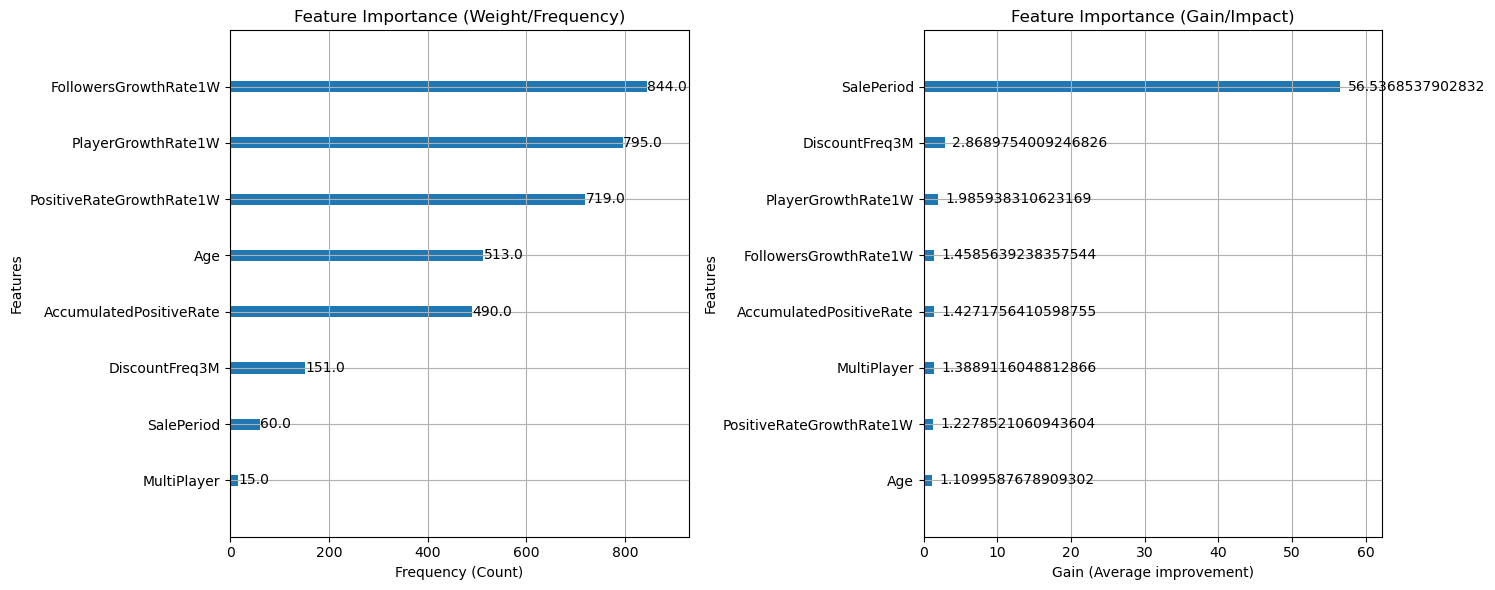


=== baseline ===
Confusion matrix:
 [[6781   13]
 [  22    6]]


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


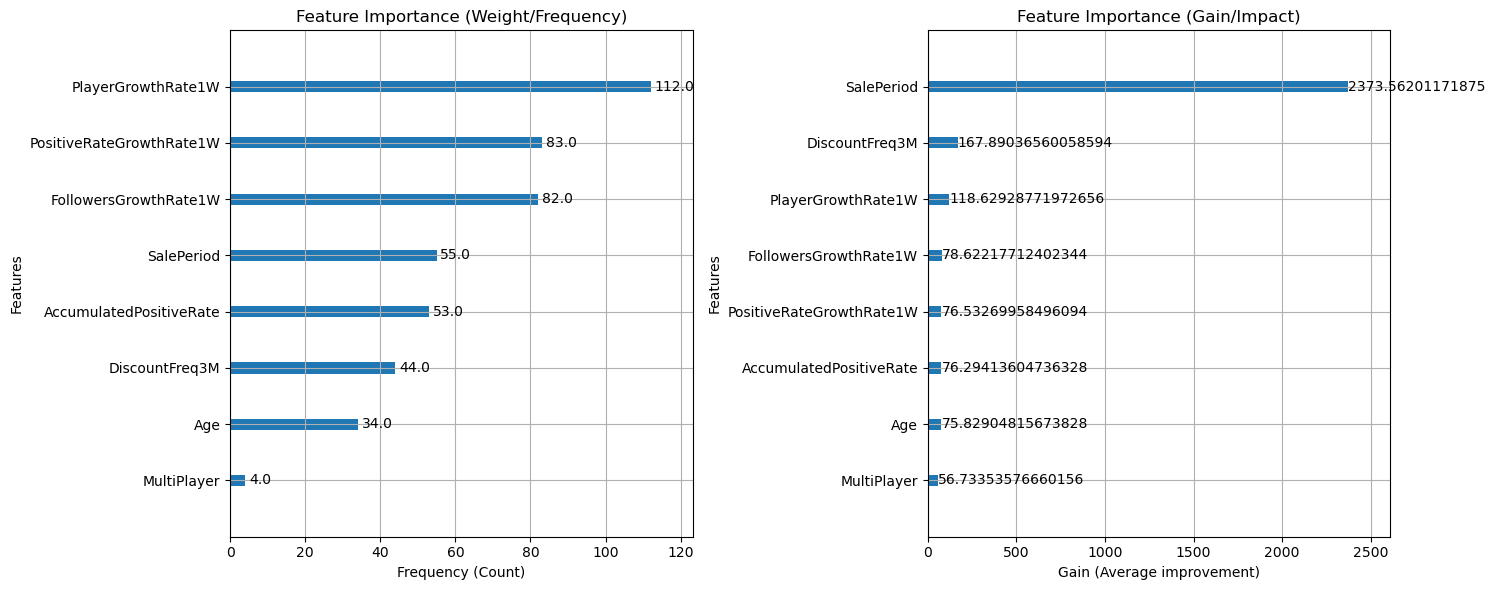


=== selection ===
Confusion matrix:
 [[6354  440]
 [   0   28]]

模型比較結果:
                 Accuracy  F1 score     AUC
baseline  train    0.9983    0.9119  1.0000
          test     0.9949    0.2553  0.9784
selection train    0.9252    0.2186  0.9809
          test     0.9355    0.1129  0.9793


In [ ]:
model = XGBClassifier( 
    random_state=71, 
    objective="binary:logistic", 
    use_label_encoder=False, 
    eval_metric='auc',
    n_estimators = 100,
    max_depth = 3,
    min_child_weight = 5,
    learning_rate = 0.1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = pos_weight
)

result1 = evaluate_model('baseline', baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model('selection', model, X_train, y_train, X_test, y_test)


combined_results = pd.concat([result1, result2], keys=['baseline', 'selection'])
print("\n模型比較結果:")
print(combined_results)

### 非季節性折扣

In [37]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountOutOfSale')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountOutOfSale')

In [38]:
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, pos_weight]
}

best_param, result = find_best_params_grid_searchCV(X_train, y_train, X_test, y_test, param_grid)
print(result)
print(best_param)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:47:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


       Accuracy  F1 score     AUC
train    0.7435    0.0699  0.9219
test     0.6117    0.0481  0.7587
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 96.25, 'subsample': 1.0}


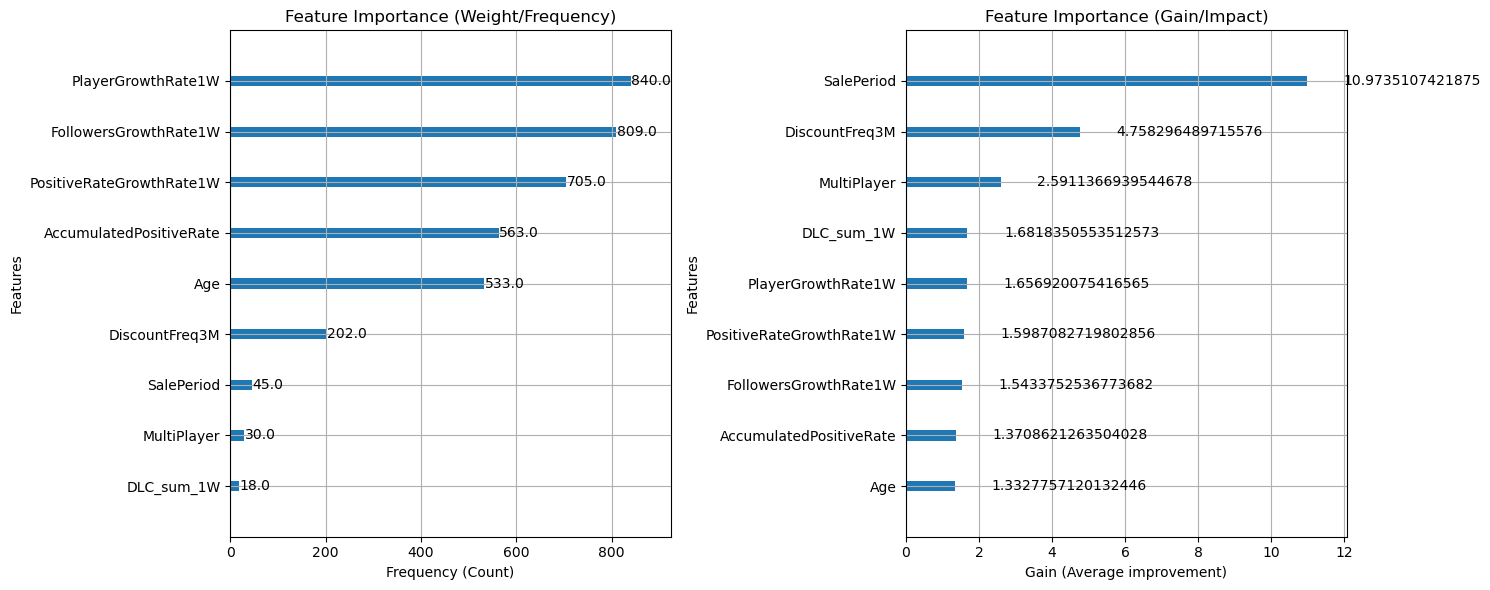


=== baseline ===
Confusion matrix:
 [[6703   26]
 [  93    0]]


c:\Users\10610\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


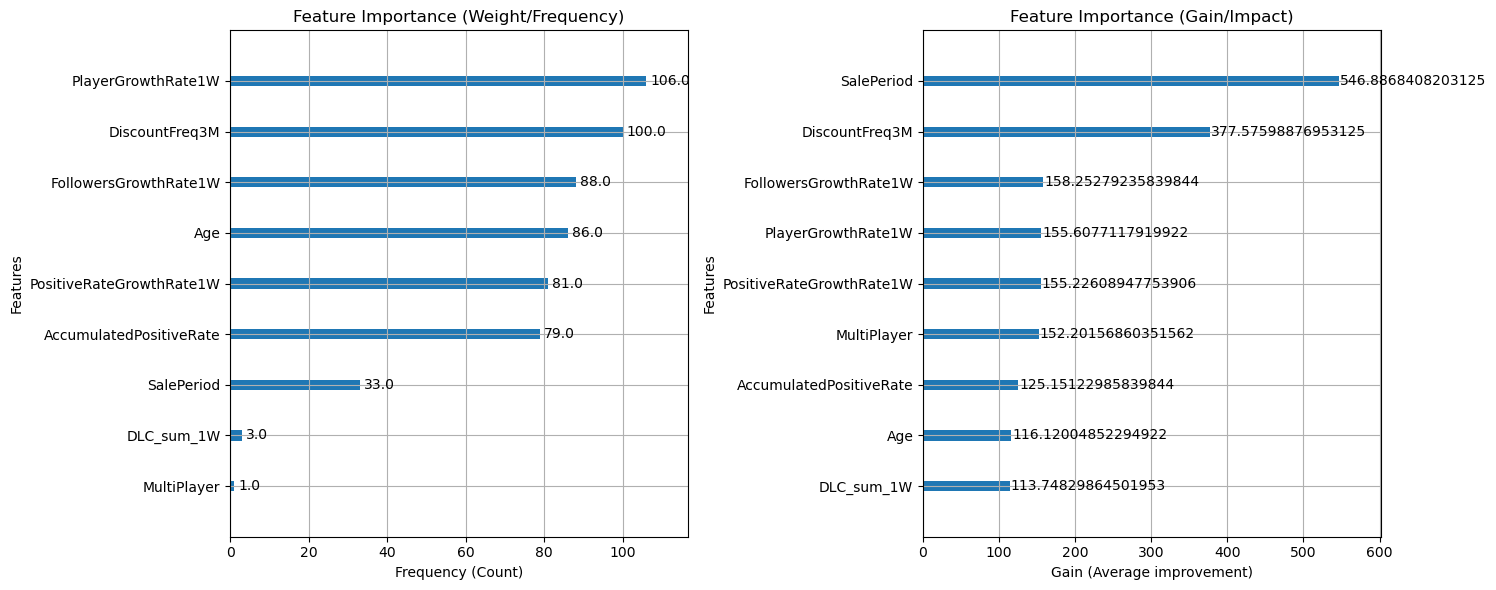


=== selection ===
Confusion matrix:
 [[4345 2384]
 [  27   66]]

模型比較結果:
                 Accuracy  F1 score     AUC
baseline  train    0.9918    0.3396  0.9994
          test     0.9826    0.0000  0.7290
selection train    0.7811    0.0823  0.9278
          test     0.6466    0.0519  0.7512


In [39]:
model = XGBClassifier( 
    random_state=71, 
    objective="binary:logistic", 
    use_label_encoder=False, 
    eval_metric='auc',
    n_estimators = 100,
    max_depth = 3,
    min_child_weight = 5,
    learning_rate = 0.1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = pos_weight
)

result1 = evaluate_model('baseline', baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model('selection', model, X_train, y_train, X_test, y_test)


combined_results = pd.concat([result1, result2], keys=['baseline', 'selection'])
print("\n模型比較結果:")
print(combined_results)